# sprint 2

## classification of resaurant
When you get restaurant recommendations as a user you might want a functionality to filter out restaurants on price range. As a restaurant owner you might want to know what other restaurant features influence your price tag. That's why we want to create a classification model that classifies restaurants into cheap, medium of expensive categories.

To do this we will try out different clasifiers on default settings and then do a gridsearch on the most promising ones to get the best model

In [295]:
from fastai.imports import *

original_df = pd.read_csv("tripadvisor_dataset/restaurant_listings.csv")
pd.set_option("display.max_columns", None)


in short, we will do the same preprocessing as we did in sprint 1

In [296]:
#see notebook sprint 1 for details on how we got this
coords=pd.read_csv("tripadvisor_dataset\coordinaten2.csv").replace(0,np.nan)

In [297]:
original_df["rank"]=original_df["rank"].str.replace("#","").astype(float)
original_df["general rating"]=original_df["general rating"].map(lambda x: x.split(" ")[0]).astype(float)
original_df["number of reviews"]=original_df["number of reviews"].map(lambda x: x.split(" ")[0].replace(",","")).astype(float)
original_df['city'] = original_df["address"].str.split(', ').str[-1].str.split(" ").str[0]
first_tag=original_df.tags.str.split("|",expand=True)[0].dropna()
ranges=first_tag[first_tag.str.find("$")!=-1]
original_df["price_tag"]=ranges
original_df=original_df.merge(coords,on="id")
original_df.drop(columns=["food rating", "service rating","price range"], inplace=True)

*NOTE* we can do this preprocessing on the original df because we are not aggregating data, each row is preprocessed individually (we are not using mean/mode/median/...)

In [298]:
original_df.columns

Index(['rank', 'restaurant name', 'general rating', 'number of reviews',
       'tags', 'address', 'phone number', 'website url', 'menu url',
       'timetable', 'email address', 'travelers choice', 'michelin',
       'value rating', 'atmosphere rating', 'description', 'dutch description',
       'cuisines', 'special diets', 'meals', 'restaurant features', 'id',
       'city', 'price_tag', 'latitude', 'longitude'],
      dtype='object')

now we will split the data and use a seed ;) but because we want to actually have price tags (our labels) we will remove them from our data first before making the train test split. In the end we can use out model to actually fill in the missing price tags 

In [299]:
df_with_price_tag=original_df[~original_df.price_tag.isna()].copy()

In [300]:
df_with_price_tag.price_tag

0       $$ - $$$
1           $$$$
2       $$ - $$$
3       $$ - $$$
4       $$ - $$$
          ...   
2563           $
2564           $
2566           $
2568    $$ - $$$
2574    $$ - $$$
Name: price_tag, Length: 1943, dtype: object

we will also remove features that won't help with the classification


In [301]:
df_with_price_tag.drop(columns=["restaurant name","address","phone number","website url","menu url","timetable","email address","id","tags"],inplace=True)

In [302]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_with_price_tag,test_size=0.2,train_size=0.8,shuffle=True,random_state=42)


Before we start with the feature engineering part I would start by making a baseline classifier, the random forest. I chose to do this because it is very difficult to do something wrong here and also hard to overfit (possible if your trees are very deep and you only have a few of them). The results are also interpretable, we can see which features are used to split our data (the most important features) and we can focus on those in our other classifier models.


inspiration from [this](https://www.kaggle.com/code/jhoward/how-random-forests-really-work) notebook used in the course [Practical Deep Learning for Coders 2022](https://www.youtube.com/watch?v=8SF_h3xF3cE&list=PLfYUBJiXbdtSvpQjSnJJ_PmDQB_VyT5iU&ab_channel=JeremyHoward)

In [303]:
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier(100, min_samples_leaf=5)
# rf.fit(trn_xs, trn_y);
# mean_absolute_error(val_y, rf.predict(val_xs))

now let's start with the feature engineering part, as we've learned our model can only interpret numbers so as input we must turn all our attributes into numerical values

for the attributes that are already numerical we can look for feature scaling methods.

### numerical values

In [304]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_cols=df_train.select_dtypes(numerics).columns

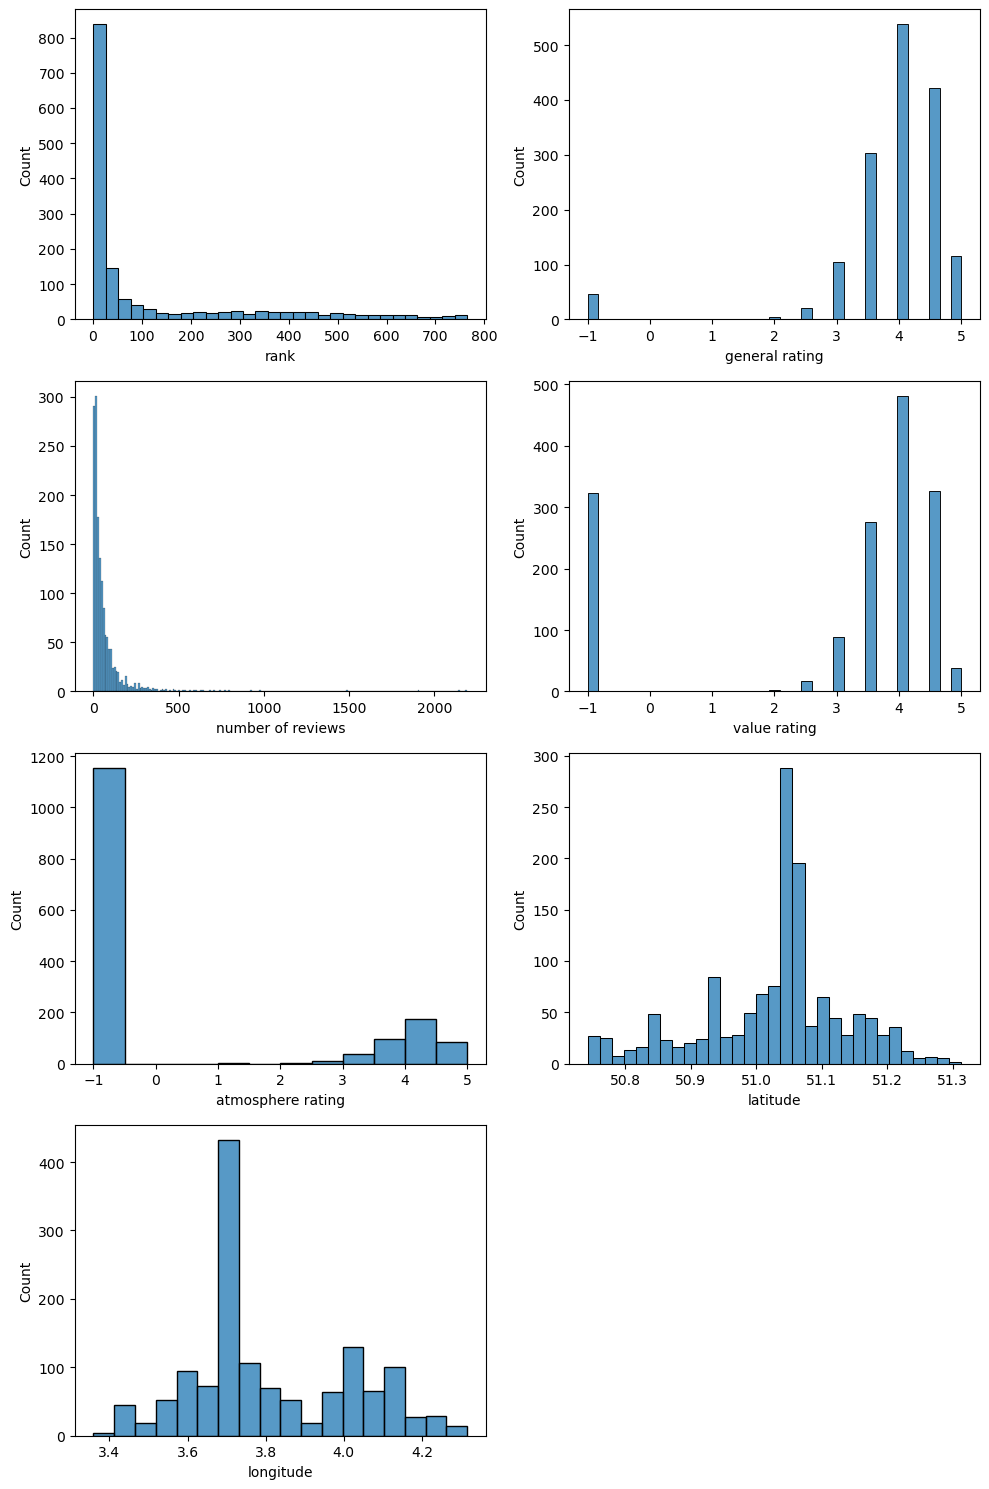

In [305]:
fig=plt.figure(figsize=(10,15))
for i, col in enumerate(numerical_cols):
    plt.subplot(4,2,i+1)
    sns.histplot(df_train[col])
fig.tight_layout()
plt.show()

#### rank and number of reviews

we can see the rank and number of reviews have along tail distribution so I would take the log of the data first, and then apply standardization.

d:\programmas_unif\miniconda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


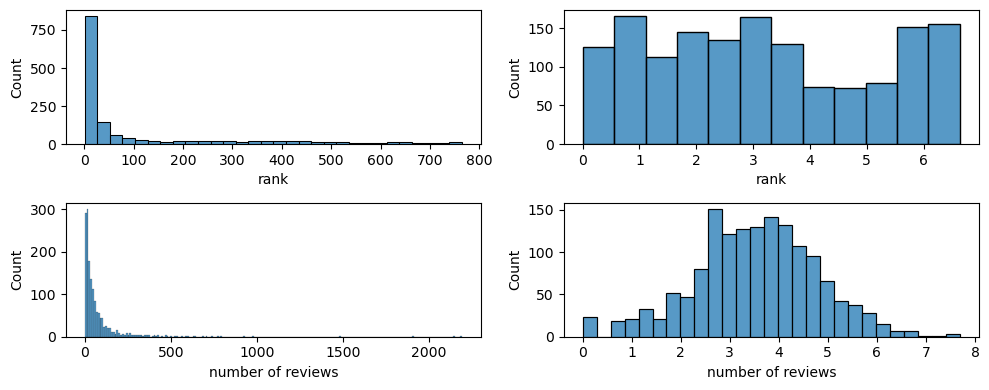

In [306]:
fig=plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
sns.histplot(df_train["rank"])
plt.subplot(2,2,2)
sns.histplot(np.log(df_train["rank"]))
plt.subplot(2,2,3)
sns.histplot(df_train["number of reviews"])
plt.subplot(2,2,4)
sns.histplot(np.log(df_train["number of reviews"]))
fig.tight_layout()
plt.show()


It already looks so much better! we will keep this but because sometimes the number of reviews is zero we will add a +1

In [307]:
##WE WILL DO THIS AFTER IMPUTATION
# df_train["lg_rank"]=np.log(df_train["rank"])
# df_train["lg_reviews"]=np.log(df_train["number of reviews"]+1)

#### general rating, atmosphere rating and value rating

look at these three again without the -1's

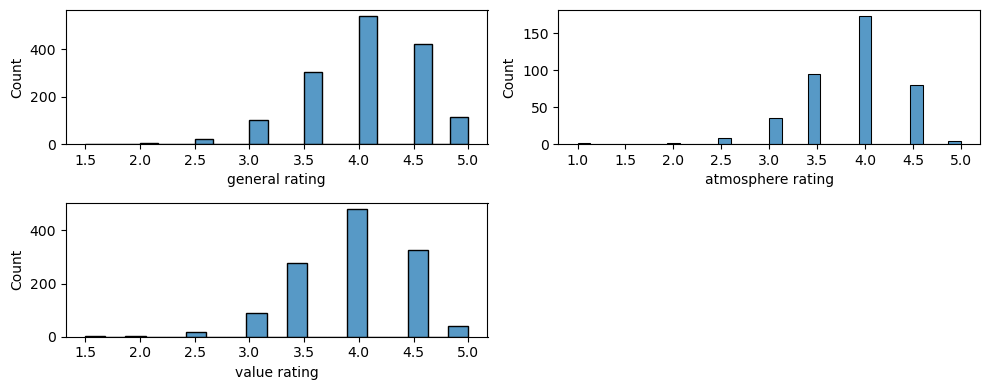

In [308]:
fig=plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
sns.histplot(df_train["general rating"].replace(-1,np.nan))
plt.subplot(2,2,2)
sns.histplot(df_train["atmosphere rating"].replace(-1,np.nan))
plt.subplot(2,2,3)
sns.histplot(df_train["value rating"].replace(-1,np.nan))
fig.tight_layout()
plt.show()

this already looks acceptable

#### lat & lon
for the coordinates we think it's best just to apply standardization to them

and for the missing data we wrote a script that derives the center latitude and longitude from the city and we will fill it in with those coordinates

#### Missing values
Because our model won't like NANs we have to replace them by something. We decided to replace them with the median of the corresponding feature. But  we also think having a missing value can actually be a very good predictor. Thats why we will ad a "missing" column when we have a missing value

In [309]:
df_train["rank_missing"]=0
df_train["atmosphere_missing"]=0
df_train["value_missing"]=0
df_train["general_missing"]=0

In [310]:
# df_train.loc[df_train["atmosphere rating"]==-1,"atmosphere rating"] = np.nan
df_train["atmosphere rating"]=df_train["atmosphere rating"].replace(-1,np.nan)
df_train["value rating"]=df_train["value rating"].replace(-1,np.nan)
df_train["general rating"]=df_train["general rating"].replace(-1,np.nan)

In [311]:
df_train.loc[df_train["rank"].isna(),"rank_missing"] = 1
df_train.loc[df_train["atmosphere rating"].isna(),"atmosphere_missing"] = 1
df_train.loc[df_train["value rating"].isna(),"value_missing"] = 1
df_train.loc[df_train["general rating"].isna(),"general_missing"] = 1

imputing our missing values with the median

In [312]:
import numpy as np
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imputed_data=imp_mean.fit_transform(df_train[["rank","general rating","value rating","atmosphere rating"]])
imputed_data

array([[  4. ,   3.5,   3. ,   4. ],
       [  6. ,   4. ,   4. ,   4. ],
       [241. ,   5. ,   4. ,   4. ],
       ...,
       [  4. ,   4.5,   4. ,   4. ],
       [ 26. ,   4.5,   4. ,   4. ],
       [ 58. ,   4. ,   4. ,   4. ]])

In [313]:
df_train["rank"]=imputed_data[:,0]
df_train["general rating"]=imputed_data[:,1]
df_train["value rating"]=imputed_data[:,2]
df_train["atmosphere rating"]=imputed_data[:,3]

scaling and then standardising

In [314]:
df_train["lg_rank"]=np.log(df_train["rank"])
df_train["lg_reviews"]=np.log(df_train["number of reviews"]+1)
df_train.drop(columns=["rank","number of reviews"],inplace=True)

In [315]:
df_train

,general rating,travelers choice,michelin,value rating,atmosphere rating,description,dutch description,cuisines,special diets,meals,restaurant features,city,price_tag,latitude,longitude,rank_missing,atmosphere_missing,value_missing,general_missing,lg_rank,lg_reviews
1817,3.5,False,False,3.0,4.0,NaN,NaN,"Seafood, Belgian, European",NaN,Dinner,"Reservations, Seating, Table Service, Wheelchair Accessible",Denderleeuw,$$ - $$$,50.888222,4.076788,0,1,0,0,1.386294,3.091042
867,4.0,False,False,4.0,4.0,NaN,NaN,"Belgian, Dutch, European",Vegetarian Friendly,"Dinner, Drinks","Reservations, Seating, Serves Alcohol, Table Service",Brakel,$$ - $$$,NaN,NaN,0,1,0,0,1.791759,3.806662
536,5.0,False,False,4.0,4.0,"A place to buy your home-made chocolate in the center of Ghent while enjoying a coffee, breakfast or lunch in a beautiful setting. We work with local products and have vegetarian dishes. All-day brunch every Saturday and every first Sunday of the month. Come and relax on our quiet and peaceful walled back terrace.",NaN,"Dutch, European",NaN,"Breakfast, Lunch, Brunch, Dinner, Drinks","Reservations, Table Service, Takeout, Seating, Wheelchair Accessible, Accepts Credit Cards",Ghent,$$ - $$$,NaN,NaN,0,1,1,0,5.484797,2.772589
1869,3.5,False,False,2.5,4.5,NaN,NaN,NaN,NaN,Drinks,"Outdoor Seating, Serves Alcohol, Seating",Ghent,$$ - $$$,51.058388,3.723831,0,0,0,0,6.418365,4.317488
1500,4.5,False,False,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Temse,$,51.115005,4.138048,0,1,1,0,2.890372,1.609438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,4.0,False,False,4.0,4.0,Typical italian pizzeria restaurant. Simple and genuine cuisine,NaN,"Italian, European",Vegetarian Friendly,"Dinner, Lunch","Takeout, Reservations, Seating, Table Service",Lokeren,$$ - $$$,51.142606,3.956006,0,1,0,0,3.044522,3.401197
1337,4.0,False,False,4.0,4.0,NaN,NaN,"Spanish, European",NaN,Dinner,"Reservations, Table Service, Seating, Wheelchair Accessible",Zottegem,$$ - $$$,50.872406,3.810749,0,1,1,0,2.944439,2.772589
865,4.5,False,False,4.0,4.0,NaN,NaN,"Belgian, Dutch, European",NaN,"Lunch, Dinner, Brunch","Reservations, Seating, Table Service, Wheelchair Accessible",Astene,$$ - $$$,NaN,NaN,0,1,0,0,1.386294,2.890372
1552,4.5,False,False,4.0,4.0,Café Inn est ouvert du mardi au mercredi de 10h à 20h. La cuisine de 12h a 18h30 non stop. Produits de saison. Pour le menu: voir la page café Inn sur FB,NaN,"Bar, Cafe, Fast Food, Pub",NaN,"Lunch, Dinner, Drinks","Serves Alcohol, Full Bar, Wine and Beer, Gift Cards Available",Ronse,$$ - $$$,NaN,NaN,0,1,1,0,3.258097,1.791759


### booleans

In [316]:
df_train.select_dtypes(bool)

,travelers choice,michelin
1817,False,False
867,False,False
536,False,False
1869,False,False
1500,False,False
...,...,...
1149,False,False
1337,False,False
865,False,False
1552,False,False


In [317]:
df_train.select_dtypes(bool).isna().sum()

travelers choice    0
michelin            0
dtype: int64

no missing values! turn these into zeros and ones

In [318]:
df_train["travelers choice"]=df_train["travelers choice"].astype(int)
df_train["michelin"]=df_train["michelin"].astype(int)

### encoding categorical variables

we already explained how we did this and used it in our sprint 1 notebook so excuse us for just copy pasting the code 😅

In [319]:
#multi hot encoding of the meals, restaurant features ,cuisines and diets
from sklearn.preprocessing import MultiLabelBinarizer

mlbs=[]
columns=["meals","restaurant features","cuisines","special diets"]
mh_encodings=[]
for col in columns:
    mlb= MultiLabelBinarizer()
    mlbs.append(mlb)
    X=df_train[col].str.replace(" ","").str.split(",").fillna("X").to_list()
    #I want a list of sets that i can then pass to the MultiLabelBinarizer
    lijst=[set(i) for i in X]
    mh_encodings.append(mlb.fit_transform(lijst))


In [320]:
for i in mh_encodings:
    print(i.shape)

(1554, 7)
(1554, 39)
(1554, 91)
(1554, 5)


one hot encode the city

In [321]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder(sparse=False,handle_unknown="infrequent_if_exist")
enc.fit(np.array(df_train["city"]).reshape(-1,1))
oh_cities=enc.transform(np.array(df_train["city"]).reshape(-1,1))
# df['city_OHE_encoded']=d
oh_cities

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [322]:
df_train.drop(columns=["cuisines","special diets","meals","restaurant features","city"],inplace=True)
df_train

,general rating,travelers choice,michelin,value rating,atmosphere rating,description,dutch description,price_tag,latitude,longitude,rank_missing,atmosphere_missing,value_missing,general_missing,lg_rank,lg_reviews
1817,3.5,0,0,3.0,4.0,NaN,NaN,$$ - $$$,50.888222,4.076788,0,1,0,0,1.386294,3.091042
867,4.0,0,0,4.0,4.0,NaN,NaN,$$ - $$$,NaN,NaN,0,1,0,0,1.791759,3.806662
536,5.0,0,0,4.0,4.0,"A place to buy your home-made chocolate in the center of Ghent while enjoying a coffee, breakfast or lunch in a beautiful setting. We work with local products and have vegetarian dishes. All-day brunch every Saturday and every first Sunday of the month. Come and relax on our quiet and peaceful walled back terrace.",NaN,$$ - $$$,NaN,NaN,0,1,1,0,5.484797,2.772589
1869,3.5,0,0,2.5,4.5,NaN,NaN,$$ - $$$,51.058388,3.723831,0,0,0,0,6.418365,4.317488
1500,4.5,0,0,4.0,4.0,NaN,NaN,$,51.115005,4.138048,0,1,1,0,2.890372,1.609438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,4.0,0,0,4.0,4.0,Typical italian pizzeria restaurant. Simple and genuine cuisine,NaN,$$ - $$$,51.142606,3.956006,0,1,0,0,3.044522,3.401197
1337,4.0,0,0,4.0,4.0,NaN,NaN,$$ - $$$,50.872406,3.810749,0,1,1,0,2.944439,2.772589
865,4.5,0,0,4.0,4.0,NaN,NaN,$$ - $$$,NaN,NaN,0,1,0,0,1.386294,2.890372
1552,4.5,0,0,4.0,4.0,Café Inn est ouvert du mardi au mercredi de 10h à 20h. La cuisine de 12h a 18h30 non stop. Produits de saison. Pour le menu: voir la page café Inn sur FB,NaN,$$ - $$$,NaN,NaN,0,1,1,0,3.258097,1.791759


#### descriptions

the only thing thats left are the descriptions, we have 2 types. We will first see which ones are the most usefull

In [323]:
print(f"description is missing: {df_train.description.isna().sum()}")
print(f"dutch description is missing {df_train['dutch description'].isna().sum()}")
print(f"size trainingsset is {len(df_train)}")

description is missing: 1191
dutch description is missing 1353
size trainingsset is 1554


we have too many missing values for description, 76% of the descriptions is missing so that's why we decided not to include this as a feature

In [324]:
df_train.drop(columns=["description","dutch description"],inplace=True)
df_train

,general rating,travelers choice,michelin,value rating,atmosphere rating,price_tag,latitude,longitude,rank_missing,atmosphere_missing,value_missing,general_missing,lg_rank,lg_reviews
1817,3.5,0,0,3.0,4.0,$$ - $$$,50.888222,4.076788,0,1,0,0,1.386294,3.091042
867,4.0,0,0,4.0,4.0,$$ - $$$,NaN,NaN,0,1,0,0,1.791759,3.806662
536,5.0,0,0,4.0,4.0,$$ - $$$,NaN,NaN,0,1,1,0,5.484797,2.772589
1869,3.5,0,0,2.5,4.5,$$ - $$$,51.058388,3.723831,0,0,0,0,6.418365,4.317488
1500,4.5,0,0,4.0,4.0,$,51.115005,4.138048,0,1,1,0,2.890372,1.609438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,4.0,0,0,4.0,4.0,$$ - $$$,51.142606,3.956006,0,1,0,0,3.044522,3.401197
1337,4.0,0,0,4.0,4.0,$$ - $$$,50.872406,3.810749,0,1,1,0,2.944439,2.772589
865,4.5,0,0,4.0,4.0,$$ - $$$,NaN,NaN,0,1,0,0,1.386294,2.890372
1552,4.5,0,0,4.0,4.0,$$ - $$$,NaN,NaN,0,1,1,0,3.258097,1.791759


### standardizing

In [337]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data=scaler.fit_transform(df_train[["general rating","value rating","atmosphere rating","latitude","longitude","lg_rank","lg_reviews"]])
scaled_data.shape

(1554, 7)

In [340]:
df_train["general rating"]=scaled_data[:,0]
df_train["value rating"]=scaled_data[:,1]
df_train["atmosphere rating"]=scaled_data[:,2]
df_train["latitude"]=scaled_data[:,3]
df_train["longitude"]=scaled_data[:,4]
df_train["lg_rank"]=scaled_data[:,5]
df_train["lg_reviews"]=scaled_data[:,6]

### label

out label is the pice tag, we will ordinal encode this

In [325]:
df_train.loc[df_train.price_tag=="$","price_tag"]=1
df_train.loc[df_train.price_tag=="$$ - $$$","price_tag"]=2
df_train.loc[df_train.price_tag=="$$$$","price_tag"]=3

In [326]:
y_train=df_train["price_tag"]
df_train.drop(columns=["price_tag"],inplace=True)

finally putting it all together

In [341]:
X=np.concatenate((oh_cities,mh_encodings[0],mh_encodings[1],mh_encodings[2],mh_encodings[3],df_train),axis=1)

# ALARM LAT EN LONG KUNNEN NOG NULL ZIJN